In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
from tqdm import tqdm
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
from sklearn.preprocessing import MinMaxScaler
import xgboost as xgb
#import lightgbm as lgb
#from catboost import CatBoostRegressor
import warnings
from sklearn.model_selection import StratifiedKFold, KFold
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, log_loss
warnings.filterwarnings('ignore')

In [2]:
data_train = pd.read_csv(r"F:\CodeApplication\Jupyter\Datawhale\train.csv")

In [3]:
data_test_a = pd.read_csv(r"F:\CodeApplication\Jupyter\Datawhale\testA.csv")

### 1.删除EDA中已发现的不需要的特征

In [4]:
#删除训练集中的重复字段n2.1，测试集中的重复字段n2.1，n2.2，n2.3，以及方差为0的变量policyCode，这里先不要删除id
data_train = data_train.drop(['n2.1','policyCode'], axis=1)
data_test_a = data_test_a.drop(['n2.1','n2.2','n2.3','policyCode'],axis=1)

In [5]:
print(data_train.shape)
print(data_test_a.shape)

(800000, 45)
(200000, 44)


### 2.填补缺失值

填补缺失值常用的方法：
1. 把所有缺失值替换为指定的值，如0：
   
   `data_train=data_train.fillna(0)`
2. 纵向用缺失值上面的值替换缺失值，可设置最多只填充几个连续的缺失值：`data_train=data_train.fillna(axis=0,method='bfill',limit=2)`

3. 也可以使用sklearn中的`sklearn.impute.SimpleImputer`来填补缺失值

4. 使用随机森林回归填补缺失值（菜菜02-3.2）

In [6]:
#划分出数据中的对象特征和数值特征
numerical_fea = list(data_train.select_dtypes(exclude=['object']).columns) 
category_fea = list(filter(lambda x: x not in numerical_fea,list(data_train.columns))) 
label = 'isDefault'
numerical_fea.remove(label)

In [7]:
#1.查看缺失值情况
data_train.isnull().sum()

id                        0
loanAmnt                  0
term                      0
interestRate              0
installment               0
grade                     0
subGrade                  0
employmentTitle           1
employmentLength      46799
homeOwnership             0
annualIncome              0
verificationStatus        0
issueDate                 0
isDefault                 0
purpose                   0
postCode                  1
regionCode                0
dti                     239
delinquency_2years        0
ficoRangeLow              0
ficoRangeHigh             0
openAcc                   0
pubRec                    0
pubRecBankruptcies      405
revolBal                  0
revolUtil               531
totalAcc                  0
initialListStatus         0
applicationType           0
earliesCreditLine         0
title                     1
n0                    40270
n1                    40270
n2                    40270
n4                    33239
n5                  

In [8]:
#按照平均数填充数值型特征
data_train[numerical_fea] = data_train[numerical_fea].fillna(data_train[numerical_fea].median())
data_test_a[numerical_fea] = data_test_a[numerical_fea].fillna(data_test_a[numerical_fea].median())

In [9]:
#按照众数填充类别型数据
data_train[category_fea] = data_train[category_fea].fillna(data_train[category_fea].median())
data_test_a[category_fea] = data_test_a[category_fea].fillna(data_test_a[category_fea].median())

In [10]:
data_train.isnull().sum()     #还差一个employmentLength没有填充

id                        0
loanAmnt                  0
term                      0
interestRate              0
installment               0
grade                     0
subGrade                  0
employmentTitle           0
employmentLength      46799
homeOwnership             0
annualIncome              0
verificationStatus        0
issueDate                 0
isDefault                 0
purpose                   0
postCode                  0
regionCode                0
dti                       0
delinquency_2years        0
ficoRangeLow              0
ficoRangeHigh             0
openAcc                   0
pubRec                    0
pubRecBankruptcies        0
revolBal                  0
revolUtil                 0
totalAcc                  0
initialListStatus         0
applicationType           0
earliesCreditLine         0
title                     0
n0                        0
n1                        0
n2                        0
n4                        0
n5                  

### 3.时间格式处理

baseline中是将年-月-日直接转化为天数，是否有其他转换方式？

In [11]:
#转化时间格式
for data in [data_train, data_test_a]:
    data['issueDate'] = pd.to_datetime(data['issueDate'], format = '%Y-%m-%d')
    startdate = datetime.datetime.strptime('2007-06-01', '%Y-%m-%d')
    #构造时间特征
    data['issueDateDT'] = data['issueDate'].apply(lambda x: x - startdate).dt.days

In [12]:
#删除原来的'issueDate'特征
data_train.drop('issueDate', axis=1, inplace=True)
data_test_a.drop('issueDate', axis=1, inplace=True)

### 4.将对象类型特征转换到数值

In [13]:
data_train_ = data_train.copy()
data_test_a_ = data_test_a.copy()

**4.1.处理特征 employmentLength -- 就业年限（年）**

In [14]:
data_train_['employmentLength'].value_counts(dropna = False).sort_index()

1 year        52489
10+ years    262753
2 years       72358
3 years       64152
4 years       47985
5 years       50102
6 years       37254
7 years       35407
8 years       36192
9 years       30272
< 1 year      64237
NaN           46799
Name: employmentLength, dtype: int64

In [15]:
#data_train_[['employmentLength','isDefault']].groupby('employmentLength').apply(lambda x:x.sum()/(data_train_['isDefault']==1).sum())

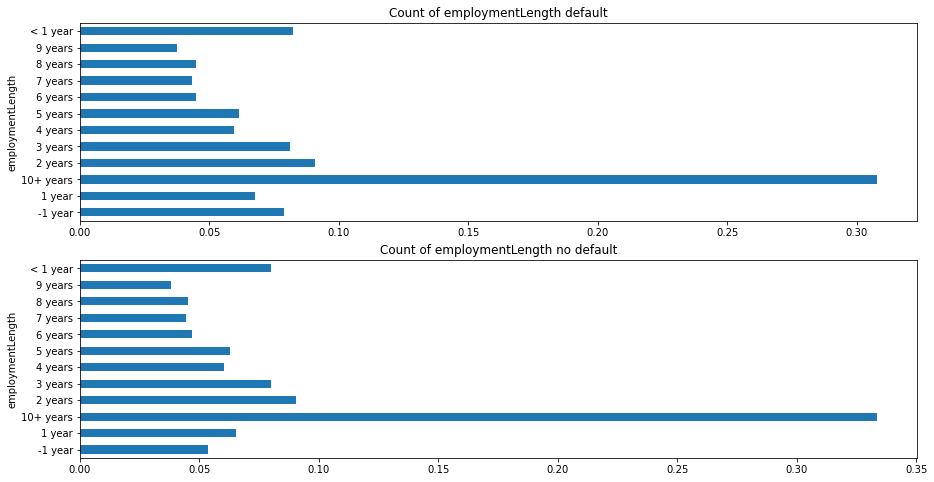

In [16]:
data_train_['employmentLength'].fillna('-1 year', inplace=True)
data_test_a_['employmentLength'].fillna('-1 year', inplace=True)

train_default = data_train_[data_train_['isDefault'] == 1]   # 违约的数据
train_no_default = data_train_[data_train_['isDefault'] == 0]  # 未违约的数据

fig,((ax1,ax2)) = plt.subplots(2, 1, figsize=(15,8))  # 创建子画布
def draw_feat_bar(data, feat, ax, title):
    """
    绘制数据分布在指定data下的结果,以比例显示
    """
    (data.groupby(feat)[feat].count()/len(data)).plot(kind='barh', ax=ax,title=title)

# df_train_default.groupby('grade')['grade'].count().plot(kind='barh',ax=ax1,title='Count of grade default')
draw_feat_bar(train_default, 'employmentLength', ax1,'Count of employmentLength default')
draw_feat_bar(train_no_default, 'employmentLength', ax2, 'Count of employmentLength no default')

这里可以将'employmentLength'的缺失值用平均数来填充，但缺失样本的违约率较高，可考虑单独分类，如-1

In [17]:
def employmentLength_to_int(s):
    if pd.isnull(s):
        return s
    else:
        return np.int8(s.split()[0])
    
for data in [data_train_, data_test_a_]: 
    data['employmentLength'].replace(to_replace='10+ years', value='10 years', inplace=True) 
    data['employmentLength'].replace('< 1 year', '0 years', inplace=True)    #小于1 year的用0来代替
    
    data['employmentLength'] = data['employmentLength'].apply(employmentLength_to_int) 

In [18]:
data_train_['employmentLength'].value_counts(dropna = False).sort_index()

-1      46799
 0      64237
 1      52489
 2      72358
 3      64152
 4      47985
 5      50102
 6      37254
 7      35407
 8      36192
 9      30272
 10    262753
Name: employmentLength, dtype: int64

In [19]:
data_test_a_['employmentLength'].value_counts(dropna = False).sort_index()

-1     11742
 0     15989
 1     13182
 2     18207
 3     16011
 4     11833
 5     12543
 6      9328
 7      8823
 8      8976
 9      7594
 10    65772
Name: employmentLength, dtype: int64

In [20]:
#用平均值填补'employmentLength'的缺失值
#data_train_['employmentLength'] = data_train_['employmentLength'].fillna(data_train_['employmentLength'].median())
#data_test_a_['employmentLength'] = data_test_a_['employmentLength'].fillna(data_test_a_['employmentLength'].median())

In [21]:
#data_train_['employmentLength'].value_counts(dropna = False).sort_index()

**4.2.对earliesCreditline - 借款人最早报告的信用额度开立的月份  进行预处理**

In [22]:
data_train_['earliesCreditLine'].sample(5)    #随机抽出5个样本

590906    Jul-2006
410661    Nov-2005
749215    Sep-2000
492380    May-1985
326784    Sep-1994
Name: earliesCreditLine, dtype: object

In [23]:
for data in [data_train_, data_test_a_]:
    data['earliesCreditLine'] = data['earliesCreditLine'].apply(lambda s : int(s[-4:]))    #只要后四位，即只管年份？

In [24]:
data_train_['earliesCreditLine'].value_counts(dropna = False).sort_index()

1944       1
1946       2
1950       5
1951       7
1952       6
        ... 
2011    9792
2012    6628
2013    3525
2014    1475
2015     201
Name: earliesCreditLine, Length: 68, dtype: int64

In [57]:
data_test_a_['earliesCreditLine'].value_counts(dropna = False).sort_index()

1944       1
1945       1
1949       1
1950       2
1951       2
        ... 
2011    2490
2012    1676
2013     850
2014     388
2015      50
Name: earliesCreditLine, Length: 69, dtype: int64

**4.3 对等级Grade，和Subgrade进行编码**

这两个特征都有明显的优先级关系，且随着grade从A至D违约率越高，subGrade从1到5违约率越高，可视为有序变量，用OridnalEncoder处理。但是如何体现他们之间的联系？或者只取subGrade，不取grade？

In [25]:
from sklearn.preprocessing import OrdinalEncoder

#OrdinalEncoder().fit(data_train['grade', 'subGrade']).categories_
data_train_.loc[:,['grade', 'subGrade']] = OrdinalEncoder().fit_transform(data_train_.loc[:,['grade', 'subGrade']])
data_test_a_.loc[:,['grade', 'subGrade']] = OrdinalEncoder().fit_transform(data_test_a_.loc[:,['grade', 'subGrade']])

In [26]:
data_train_.loc[:,['grade', 'subGrade']]

,grade,subGrade
0,4.0,21.0
1,3.0,16.0
2,3.0,17.0
3,0.0,3.0
4,2.0,11.0
...,...,...
799995,2.0,13.0
799996,0.0,3.0
799997,2.0,12.0
799998,0.0,3.0


到这里对象类型的特征就处理完了，接下来考虑处理数值类型中的离散变量

### 5.类别特征处理

In [27]:
#查看各特征的类型数
cate_features = ['employmentTitle','homeOwnership', 'verificationStatus', 'purpose', 'postCode', 'regionCode',  'applicationType', 'initialListStatus', 'title'] 
for f in cate_features: 
    print(f, '类型数：', data_train_[f].nunique())

employmentTitle 类型数： 248683
homeOwnership 类型数： 6
verificationStatus 类型数： 3
purpose 类型数： 14
postCode 类型数： 932
regionCode 类型数： 51
applicationType 类型数： 2
initialListStatus 类型数： 2
title 类型数： 39644


#### 5.1. 高维类别特征

遇到的问题： employmentTitle , title , postCode有这么多类别，该如何处理？

baseline中对它们进行了计数聚合，排序，不太理解。

```python
for f in ['employmentTitle', 'postCode', 'title']:
    data[f+'_cnts'] = data.groupby([f])['id'].transform('count')
    data[f+'_rank'] = data.groupby([f])['id'].rank(ascending=False).astype(int)    #和上一列完全一样？
    del data[f]
```

In [58]:
data_train_1 = data_train_.copy()
data_test_a_1 = data_test_a_.copy()

In [59]:
#data = pd.concat([data_train_1, data_test_a_1], axis=0, ignore_index=True)

In [60]:
# 高维类别特征需要进行转换
for col in tqdm(['employmentTitle', 'postCode', 'title']):
    le = LabelEncoder()   #labelEncoder可以将标签分配一个0-n_classes-1之间的编码
    #但这样做就是认为变量之间是有序或者有距的了，是否可以？
    
    le.fit(list(data_train_1[col].astype(str).values) + list(data_test_a_1[col].astype(str).values))
    data_train_1[col] = le.transform(list(data_train_1[col].astype(str).values))
    data_test_a_1[col] = le.transform(list(data_test_a_1[col].astype(str).values))
print('Label Encoding 完成')

100%|██████████| 3/3 [00:04<00:00,  1.61s/it]

Label Encoding 完成


#### 5.2. 类型数较少的变量用OneHot

类型数在2之上，又不是高维稀疏的，且纯分类特征，可视为名义变量，用OneHot编码处理。

其中regiocode有51个类别，会不会有点多，需不需要进一步处理？

In [61]:
#for data in [data_train_1, data_test_a_1]:
data_train_1 = pd.get_dummies(data_train_1, columns = ['verificationStatus', 'initialListStatus','applicationType', 'purpose', 'regionCode'], drop_first = True)
data_test_a_1 = pd.get_dummies(data_test_a_1, columns = ['verificationStatus', 'initialListStatus','applicationType', 'purpose', 'regionCode'], drop_first = True)

这里drop_first = True，去掉了第一个类别，为什么？

找到的一个讨论：[When should we drop_first in get_dummies?](https://www.kaggle.com/c/instant-gratification/discussion/92817)

In [62]:
data_train_1.head()

,id,loanAmnt,term,interestRate,installment,grade,subGrade,employmentTitle,employmentLength,homeOwnership,...,regionCode_41,regionCode_42,regionCode_43,regionCode_44,regionCode_45,regionCode_46,regionCode_47,regionCode_48,regionCode_49,regionCode_50
0,0,35000.0,5,19.52,917.97,4.0,21.0,192025,2,2,...,0,0,0,0,0,0,0,0,0,0
1,1,18000.0,5,18.49,461.90,3.0,16.0,104733,5,0,...,0,0,0,0,0,0,0,0,0,0
2,2,12000.0,5,16.99,298.17,3.0,17.0,189509,8,0,...,0,0,0,0,0,0,0,0,0,0
3,3,11000.0,3,7.26,340.96,0.0,3.0,249631,10,1,...,0,0,0,0,0,0,0,0,0,0
4,4,3000.0,3,12.99,101.07,2.0,11.0,256267,-1,1,...,0,0,0,0,0,0,0,0,0,0


In [63]:
#features = [f for f in data.columns if f not in ['id','isDefault']]

#data_train_2 = data[data.isDefault.notnull()].reset_index(drop=True)
#data_test_a_2 = data[data.isDefault.isnull()].reset_index(drop=True)

### 6.异常值处理

>现实数据总会有一些异常值，我们需要把它们捕捉出来，然后观察它们的性质。但并不是要排除所有异常值，相反有时候异常值也是重点研究对象。处理异常值可以用**箱线法，或者$3\sigma$法则**。在银行数据中，我们希望排除的“异常值”可能不是一些超高或超低的数字，而是一些不合理的数字，如loanAmnt-贷款金额可以很高，但不能为负数。

暂时没有进行异常值处理。

In [64]:
#描述性统计
data_train_1.describe([0.01, 0.1, 0.25, 0.5, 0.75, 0.9, 0.99])

,id,loanAmnt,term,interestRate,installment,grade,subGrade,employmentTitle,employmentLength,homeOwnership,...,regionCode_41,regionCode_42,regionCode_43,regionCode_44,regionCode_45,regionCode_46,regionCode_47,regionCode_48,regionCode_49,regionCode_50
count,800000.000000,800000.000000,800000.000000,800000.000000,800000.000000,800000.000000,800000.000000,800000.000000,800000.000000,800000.000000,...,800000.000000,800000.000000,800000.000000,800000.000000,800000.000000,800000.000000,800000.000000,800000.00000,800000.000000,800000.000000
mean,399999.500000,14416.818875,3.482745,13.238391,437.947723,1.745472,10.691510,164744.594133,5.557749,0.614213,...,0.002223,0.009084,0.009626,0.004954,0.007415,0.001191,0.001516,0.00235,0.001251,0.000008
std,230940.252013,8716.086178,0.855832,4.765757,261.460393,1.294173,6.446515,93876.984767,3.936252,0.675749,...,0.047091,0.094875,0.097640,0.070208,0.085791,0.034494,0.038910,0.04842,0.035351,0.002739
min,0.000000,500.000000,3.000000,5.310000,15.690000,0.000000,0.000000,0.000000,-1.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000
1%,7999.990000,1500.000000,3.000000,5.320000,53.150000,0.000000,0.000000,2092.000000,-1.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000
10%,79999.900000,5000.000000,3.000000,7.390000,157.590000,0.000000,3.000000,29099.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000
25%,199999.750000,8000.000000,3.000000,9.750000,248.450000,1.000000,6.000000,77517.000000,2.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000
50%,399999.500000,12000.000000,3.000000,12.740000,375.135000,2.000000,10.000000,178975.500000,6.000000,1.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000
75%,599999.250000,20000.000000,3.000000,15.990000,580.710000,2.000000,14.000000,256267.000000,10.000000,1.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000
90%,719999.100000,28000.000000,5.000000,19.480000,807.300000,4.000000,20.000000,274105.000000,10.000000,2.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000


### 7.待学习的方法

* 数据分桶
* 特征交互
* 特征选择
* 特征创造

### Task3小结

* 按照教程的方法进行了基本的特征工程
* 需要做进一步尝试：
    1. grade, subGrade，尝试只保留subGrade？
    2. 与时间有关的特征如何进一步处理，issueDateDT，employmentLength，earliesCreditLine
    3. 数值跨域大的特征进行分箱
    4. 特征选择与特征创造
    
***********************************

In [65]:
#保存处理好的数据
data_train_1.to_csv('data_train_for_model.csv')

In [65]:
data_test_a_1.to_csv('data_test_for_model.csv')

In [66]:
#reduce_mem_usage 函数通过调整数据类型，帮助我们减少数据在内存中占用的空间
def reduce_mem_usage(df):
    start_mem = df.memory_usage().sum() 
    print('Memory usage of dataframe is {:.2f} MB'.format(start_mem))
    
    for col in df.columns:
        col_type = df[col].dtype
        
        if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
        else:
            df[col] = df[col].astype('category')

    end_mem = df.memory_usage().sum() 
    print('Memory usage after optimization is: {:.2f} MB'.format(end_mem))
    print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))
    
    return df

In [67]:
#训练数据/测试数据准备

data_train = pd.read_csv('data_train_for_model.csv')
data_train = reduce_mem_usage(data_train)

data_test = pd.read_csv('data_test_for_model.csv')
data_test = reduce_mem_usage(data_test)

Memory usage of dataframe is 691200128.00 MB
Memory usage after optimization is: 125600128.00 MB
Decreased by 81.8%
Memory usage of dataframe is 171200128.00 MB
Memory usage after optimization is: 31200128.00 MB
Decreased by 81.8%


In [68]:
features = [f for f in data_train.columns if f not in ['id','isDefault']]

x_train = data_train[features]
x_test = data_test[features]

y_train = data_train['isDefault']

In [69]:
# 5折交叉验证

folds = 5
seed = 2020
kf = KFold(n_splits=folds, shuffle=True, random_state=seed)

In [72]:
#模型训练

from sklearn.model_selection import cross_val_score as CVS, train_test_split as TTS

cv_scores = []
for i, (train_index, valid_index) in enumerate(kf.split(x_train, y_train)):
    print('************************************ {} ************************************'.format(str(i+1)))
    X_train_split, y_train_split, X_val, y_val = x_train.iloc[train_index], y_train[train_index], x_train.iloc[valid_index], y_train[valid_index]
    
    train_matrix = xgb.DMatrix(X_train_split, label=y_train_split)
    valid_matrix = xgb.DMatrix(X_val, label=y_val)
    test_matrix = xgb.DMatrix(x_test)

    params = {'booster': 'gbtree',
              'objective': 'binary:logistic',
              'eval_metric': 'auc',
              'gamma': 1,
              'min_child_weight': 1.5,
              'max_depth': 5,
              'lambda': 10,
              'subsample': 0.7,
              'colsample_bytree': 0.7,
              'colsample_bylevel': 0.7,
              'eta': 0.04,
              'tree_method': 'exact',     # ?
              'seed': 2020,
              'nthread': -1,
              "silent": True,
              }
    watchlist = [(train_matrix, 'train'),(valid_matrix, 'eval')]
    
    model = xgb.train(params, train_matrix, 
                      num_boost_round=4000, 
                      evals=watchlist, 
                      verbose_eval=200,    # ?
                      early_stopping_rounds=200)
    val_pred  = model.predict(valid_matrix, ntree_limit=model.best_ntree_limit)
    test_pred = model.predict(test_matrix , ntree_limit=model.best_ntree_limit)
    
    #train[valid_index] = val_pred
    #test = test_pred / kf.n_splits
    cv_scores.append(roc_auc_score(y_val, val_pred))
    print(cv_scores)

print("xgb_scotrainre_list:{}".format(cv_scores))
print("xgb_score_mean:{}".format(np.mean(cv_scores)))
print("xgb_score_std:{}".format(np.std(cv_scores)))

************************************ 1 ************************************
[0]	train-auc:0.697491	eval-auc:0.69737
Multiple eval metrics have been passed: 'eval-auc' will be used for early stopping.

Will train until eval-auc hasn't improved in 200 rounds.
[200]	train-auc:0.732393	eval-auc:0.730048
[400]	train-auc:0.739699	eval-auc:0.733595
[600]	train-auc:0.744892	eval-auc:0.735325
[800]	train-auc:0.748952	eval-auc:0.736265
[1000]	train-auc:0.752616	eval-auc:0.736874
[1200]	train-auc:0.755979	eval-auc:0.737332
[1400]	train-auc:0.759018	eval-auc:0.737645
[1600]	train-auc:0.761998	eval-auc:0.737832
[1800]	train-auc:0.765064	eval-auc:0.738043
[2000]	train-auc:0.767845	eval-auc:0.738175
[2200]	train-auc:0.770536	eval-auc:0.73833
[2400]	train-auc:0.773137	eval-auc:0.738376
[2600]	train-auc:0.775613	eval-auc:0.738437
[2800]	train-auc:0.778074	eval-auc:0.738441
[3000]	train-auc:0.780598	eval-auc:0.738502
Stopping. Best iteration:
[2967]	train-auc:0.780189	eval-auc:0.738507



NameError: name 'val_y' is not defined

In [75]:
test_pred.shape

(200000,)

In [76]:
data_test['isDefault'] = test_pred

In [77]:
data_test[['id','isDefault']].to_csv('test_sub.csv', index=False)